#### Imports

In [1]:
#Imports
import re

import unicodedata
import nltk
from wordcloud import WordCloud

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import env

# Exercises

### 1. Spam Data

a. Load the spam data set.  


In [2]:
#Get SQL database url
url = env.get_db_url('spam_db')

In [3]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [4]:
#Read SQL
df = pd.read_sql(query, url)

In [5]:
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [7]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(' '.join(df[df.label=='ham']['text']))
spam_words = clean(' '.join(df[df.label=='spam']['text']))
all_words = clean(' '.join(df['text']))

In [8]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [9]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['ham', 'spam', 'all']

word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [124]:
def make_ngrams(words, n):
    return pd.Series(nltk.ngrams(words, n)).value_counts().head(20)

b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?  
c. Is there any overlap in the bigrams for the spam data and the ham data?  

In [11]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

<AxesSubplot:>

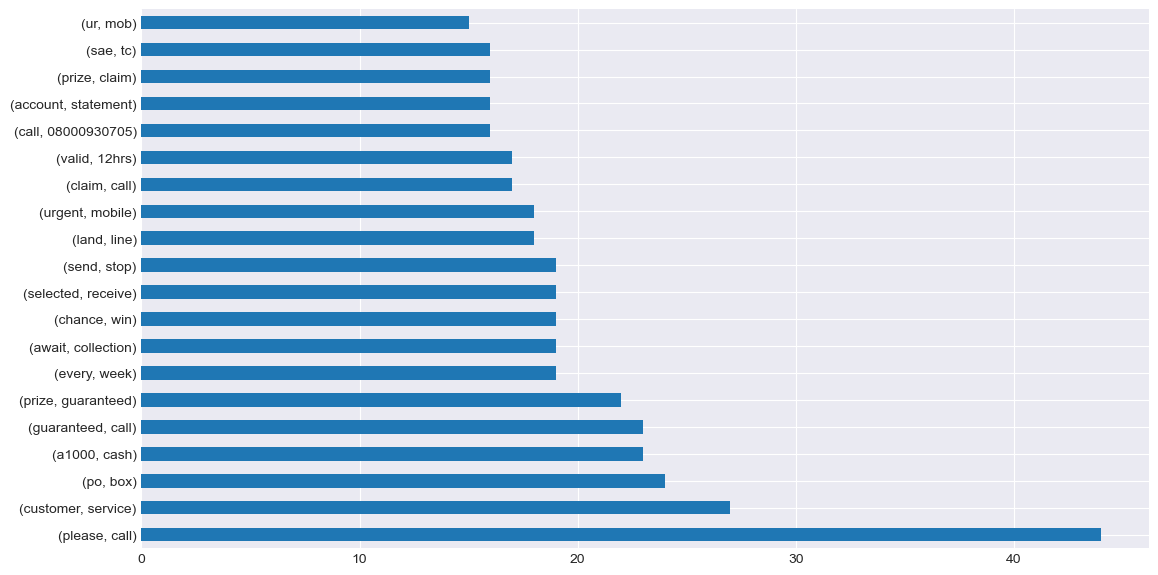

In [12]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(20).plot.barh()

In [33]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

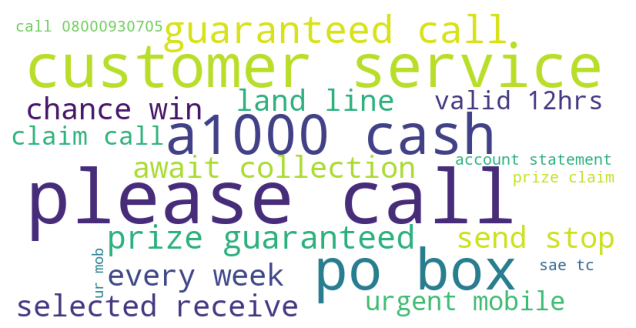

In [34]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.
# k = key, v = value or frequency

data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [112]:
def plot_bigrams(words):
    word_data = {k[0] + ' ' + k[1]: v for k, v in words.to_dict().items()}
    
    word_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_data)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(word_img)
    plt.axis('off')
    plt.show()

<AxesSubplot:>

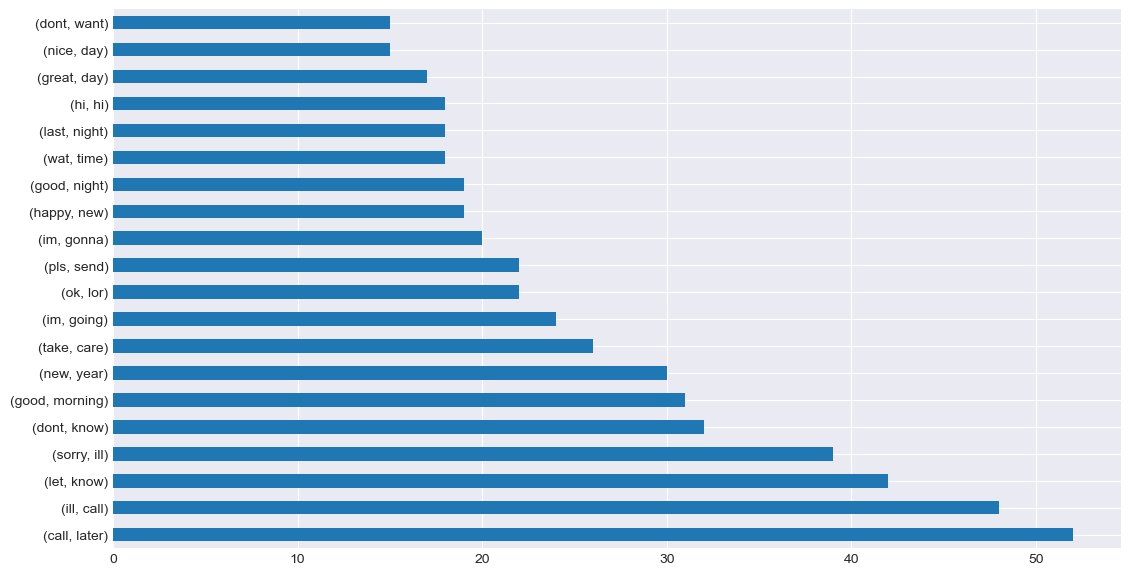

In [13]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(20).plot.barh()

In [31]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

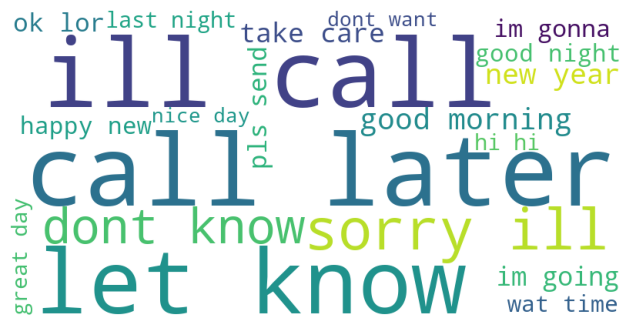

In [113]:
plot_bigrams(top_20_ham_bigrams)

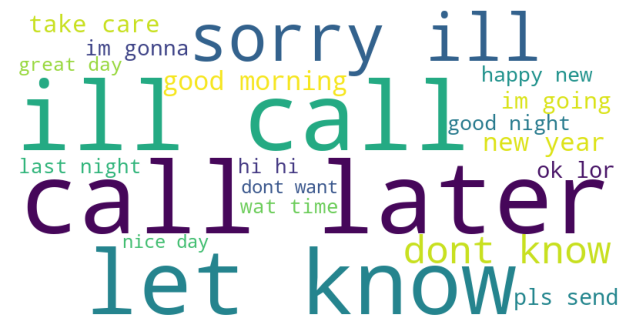

In [32]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

----
overlap

In [114]:
overlap_list = [bigram for bigram in top_20_spam_bigrams.keys() if bigram in top_20_ham_bigrams.keys()]
overlap_list

[]

d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [36]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(reply, call, 08000930705)    14
(land, line, claim)           14
(private, 2003, account)      13
dtype: int64

<AxesSubplot:>

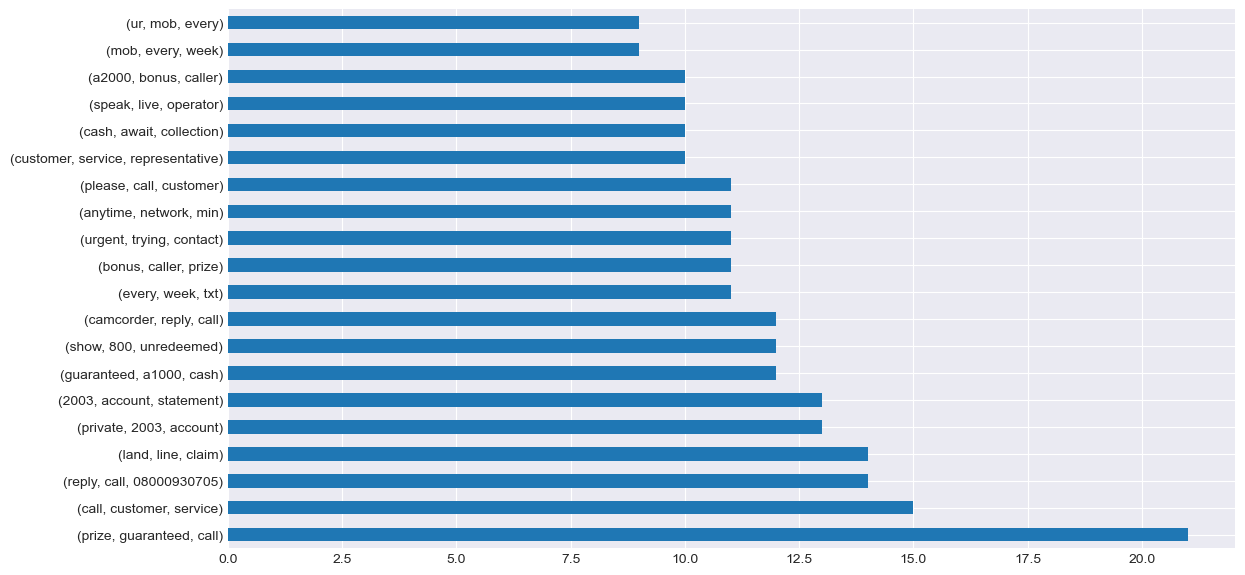

In [40]:
pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20).plot.barh()

In [37]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(pick, phone, right)    12
dtype: int64

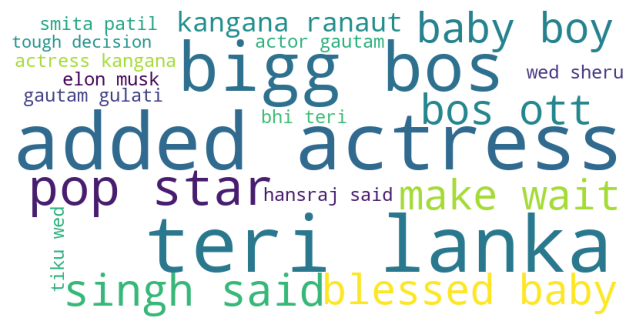

In [118]:
spam_trigram_data = {k[0]+ ' '+k[1]+ ' '+k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
spam_tirgram_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(spam_trigram_data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

<AxesSubplot:>

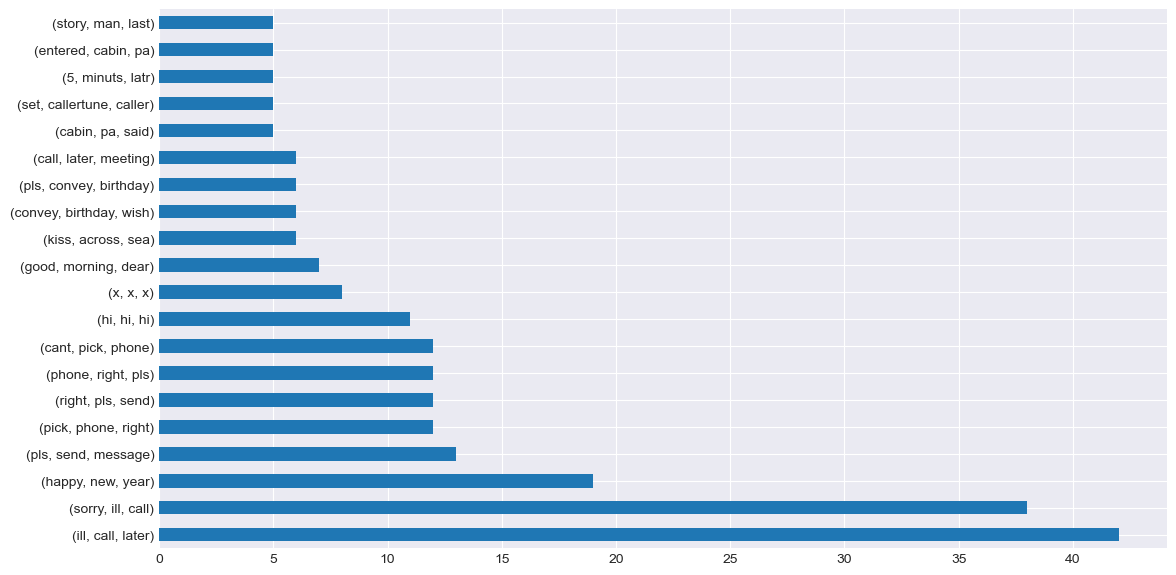

In [39]:
pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20).plot.barh()

---

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [46]:
import acquire
import prepare

In [52]:
from requests import get

In [54]:
import requests

In [56]:
from bs4 import BeautifulSoup

In [47]:
acquire.acquire_info()

get_blog_articles2()
scrape_one_page(topic)
get_news_articles(topic_list)


In [48]:
prepare.prepare_info()

basic_clean(original)
tokenize(basic_cleaned)
remove_stopwords(lemma_or_stem)
stem(clean_tokenize)
lemmatize(clean_tokenize)


In [ ]:
acquire.get_blog_articles2()

In [49]:
def get_all_articles(url):
    article_list = []
    headers = {"User-Agent": "Chrome/91.0.4472.124"}

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the href attribute from <a> tags with class 'more-link'
    links = soup.find_all('a', class_='more-link')
    link_list = [link['href'] for link in links]

    for link in link_list:
        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        title = soup.find('h1', class_='entry-title').text
        divcont = soup.find('div', class_='entry-content')
        article = [para.text for para in divcont.find_all('p')]

        article_nl = ' '.join(article)

        article_dict = {'title': title, 'content': article_nl}
        article_list.append(article_dict)

    codeup_df = pd.DataFrame(article_list)

    return codeup_df

In [57]:
blogs = get_all_articles('https://codeup.com/blog/')

In [58]:
blogs

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Codeup is hosting a Women in Tech Panel in hon...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Codeup is hosting a Women in Tech Panel in hon...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Codeup is hosting a Women in Tech Panel in hon...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Codeup is hosting a Women in Tech Panel in hon...
5,Black Excellence in Tech: Panelist Spotlight –...,Codeup is hosting a Black Excellence in Tech ...


In [64]:
blogs

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Codeup is hosting a Women in Tech Panel in hon...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Codeup is hosting a Women in Tech Panel in hon...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Codeup is hosting a Women in Tech Panel in hon...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Codeup is hosting a Women in Tech Panel in hon...
5,Black Excellence in Tech: Panelist Spotlight –...,Codeup is hosting a Black Excellence in Tech ...


In [75]:
blogs['clean_norm_token'] = blogs.content.apply(prepare.basic_clean).apply(prepare.tokenize).apply(prepare.remove_stopwords)

In [77]:
blogs['lemmatized'] = blogs.clean_norm_token.apply(prepare.lemmatize)

In [78]:
blogs

,title,content,clean_norm_token,lemmatized
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...,may traditionally known asian american pacific...,may traditionally known asian american pacific...
1,Women in tech: Panelist Spotlight – Magdalena ...,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
5,Black Excellence in Tech: Panelist Spotlight –...,Codeup is hosting a Black Excellence in Tech ...,codeup hosting black excellence tech panel hon...,codeup hosting black excellence tech panel hon...


In [81]:
blog_words = clean(' '.join(blogs['lemmatized']))

In [83]:
blog_freq = pd.Series(blog_words).value_counts()

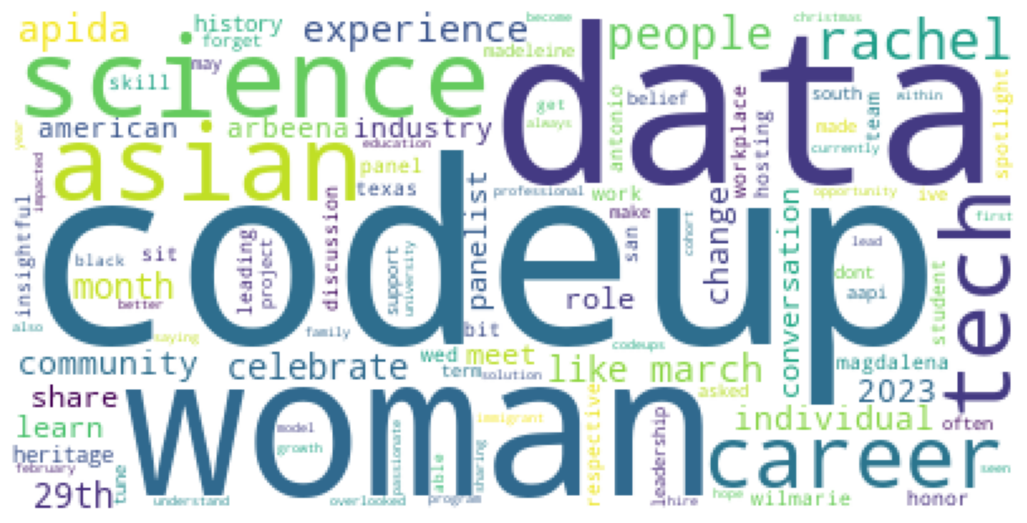

In [122]:
blog_img = WordCloud(background_color='white').generate_from_frequencies(blog_freq)
plt.imshow(blog_img)
plt.axis('off')
plt.show()

<AxesSubplot:>

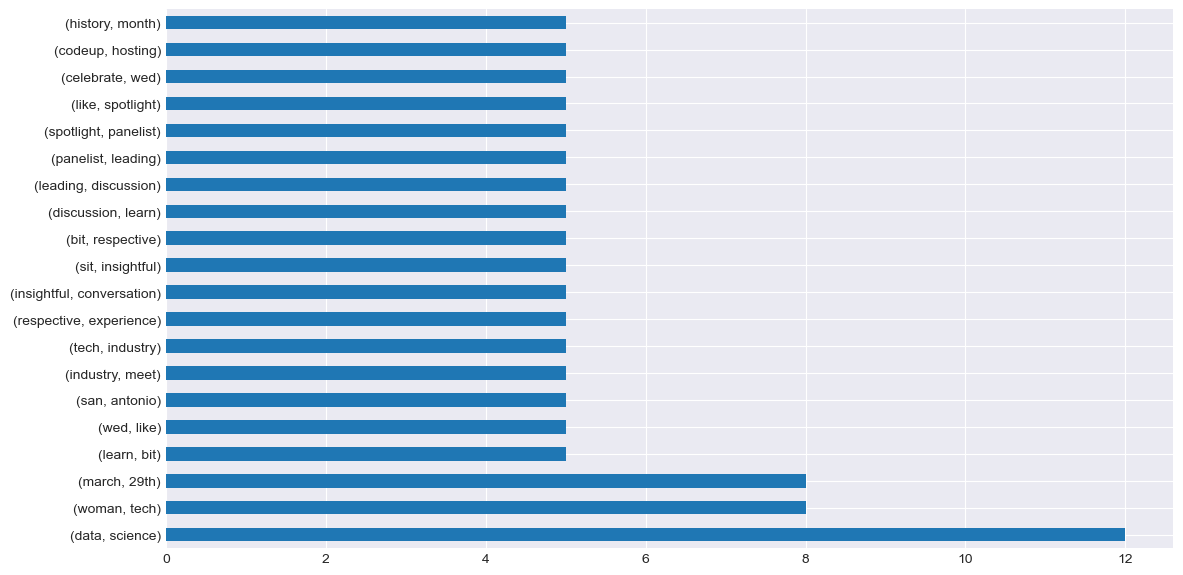

In [84]:
pd.Series(nltk.bigrams(blog_words)).value_counts().head(20).plot.barh()

In [85]:
top_20_blog_bigrams = (pd.Series(nltk.ngrams(blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_blog_bigrams.head()

(data, science)    12
(woman, tech)       8
(march, 29th)       8
(learn, bit)        5
(wed, like)         5
dtype: int64

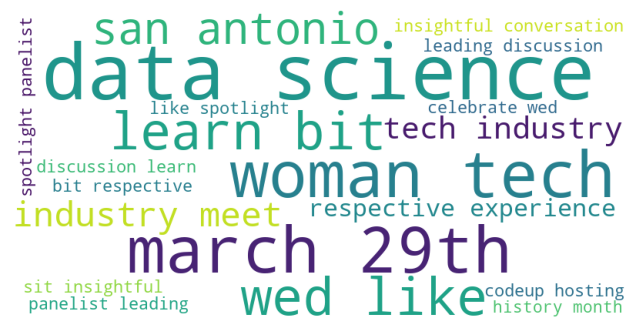

In [86]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [125]:
top_20_blog_trigram = make_ngrams(blog_words, 3)
top_20_blog_trigram

(leading, discussion, learn)       5
(tech, panel, honor)               5
(bit, respective, experience)      5
(learn, bit, respective)           5
(discussion, learn, bit)           5
(tech, industry, meet)             5
(panelist, leading, discussion)    5
(spotlight, panelist, leading)     5
(like, spotlight, panelist)        5
(wed, like, spotlight)             5
(celebrate, wed, like)             5
(2023, celebrate, wed)             5
(sit, insightful, conversation)    5
(woman, tech, panel)               4
(hosting, woman, tech)             4
(codeup, hosting, woman)           4
(panel, honor, woman)              4
(woman, tech, industry)            4
(experience, woman, tech)          4
(respective, experience, woman)    4
dtype: int64

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [87]:
topic_list = ['business', 'sports', 'technology', 'entertainment']

In [88]:
final_list = acquire.get_news_articles(topic_list)

In [90]:
news_df = pd.DataFrame(final_list)
news_df

,category,title,content
0,business,"Sensex, Nifty end at fresh closing highs",Benchmark indices Sensex and Nifty ended at re...
1,business,TIME releases list of the world's 100 most inf...,TIME magazine has released its annual list of ...
2,business,Which are the world's top 10 airlines accordin...,Singapore Airlines is the world's best airline...
3,business,"Loves India, is a fan of PM: Paytm Founder on ...",Paytm Founder Vijay Shekhar Sharma shared a vi...
4,business,UK's net debt passes 100% of GDP for the first...,The United Kingdom's public sector net debt in...
...,...,...,...
95,entertainment,"Of course, why not: Gautam Gulati on if he wou...","Actor Gautam Gulati, when asked if he would ev..."
96,entertainment,Rajamouli said Baahubali was litmus test for M...,\nSS Rajamouli's father and writer Vijayendra ...
97,entertainment,Admire her audacity: Mahesh Bhatt on Pooja ent...,Filmmaker Mahesh Bhatt reacted to his daughter...
98,entertainment,I lost reputation the first day I started work...,"Cyrus Broacha said he ""needed new ways of earn..."


In [92]:
news_df['clean_norm_token'] = news_df.content.apply(prepare.basic_clean).apply(prepare.tokenize).apply(prepare.remove_stopwords)

In [94]:
news_df['lemmatized'] = news_df.clean_norm_token.apply(prepare.lemmatize)

In [99]:
news_df.head(1)

,category,title,content,clean_norm_token,lemmatized
0,business,"Sensex, Nifty end at fresh closing highs",Benchmark indices Sensex and Nifty ended at re...,benchmark indices sensex nifty ended record cl...,benchmark index sensex nifty ended record clos...


In [98]:
news_df.category.value_counts()

business         25
sports           25
technology       25
entertainment    25
Name: category, dtype: int64

In [100]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

business_words = clean(' '.join(news_df[news_df.category=='business']['lemmatized']))
sports_words = clean(' '.join(news_df[news_df.category=='sports']['lemmatized']))
tech_words = clean(' '.join(news_df[news_df.category=='technology']['lemmatized']))
ent_words = clean(' '.join(news_df[news_df.category=='entertainment']['lemmatized']))
all_words = clean(' '.join(news_df['lemmatized']))

In [101]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

business_freq = pd.Series(business_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
tech_freq = pd.Series(tech_words).value_counts()
ent_freq = pd.Series(ent_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [102]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([business_freq, sports_freq, tech_freq, ent_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['business', 'sports', 'tech', 'entertainment', 'all']

word_counts.head()

,business,sports,tech,entertainment,all
said,16,12,22,24,74
india,10,4,13,0,27
wednesday,10,1,2,1,14
share,8,2,1,0,11
yoga,7,2,0,0,9


<AxesSubplot:>

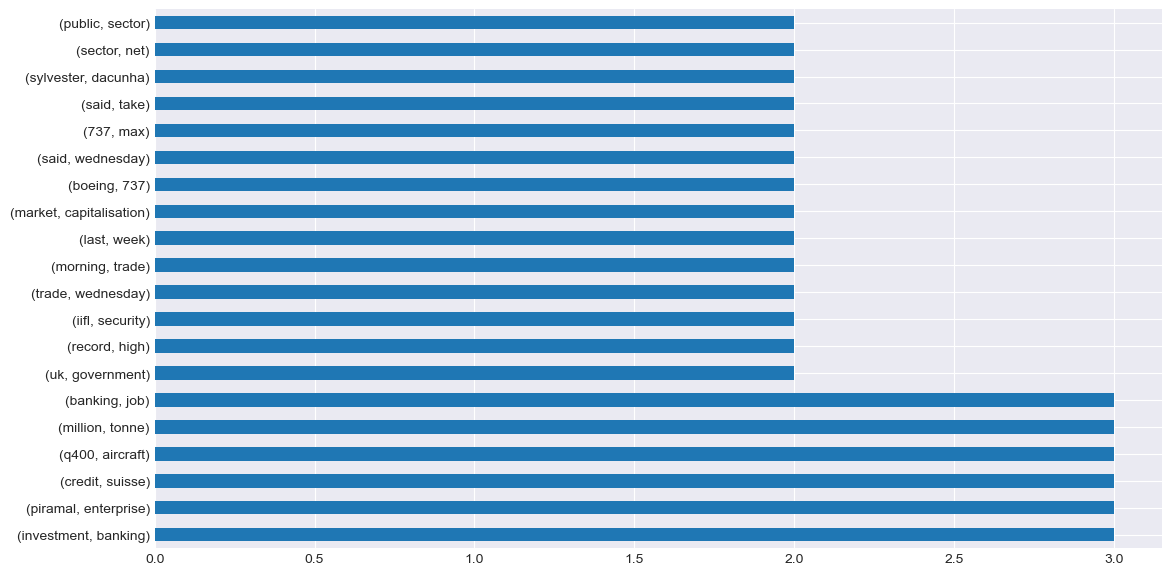

In [103]:
pd.Series(nltk.bigrams(business_words)).value_counts().head(20).plot.barh()

In [104]:
top_20_business_bigrams = (pd.Series(nltk.ngrams(business_words, 2))
                      .value_counts()
                      .head(20))

top_20_business_bigrams.head()

(investment, banking)    3
(piramal, enterprise)    3
(credit, suisse)         3
(q400, aircraft)         3
(million, tonne)         3
dtype: int64

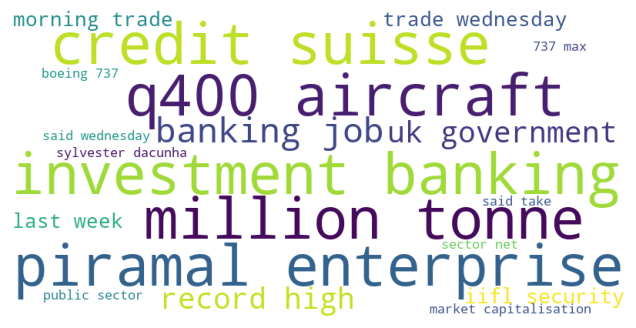

In [105]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_business_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [106]:
top_20_sports_bigrams = (pd.Series(nltk.ngrams(sports_words, 2))
                      .value_counts()
                      .head(20))

top_20_sports_bigrams.head()

(ash, 2023)          7
(2023, test)         6
(first, ash)         6
(edgbaston, test)    4
(pat, cummins)       4
dtype: int64

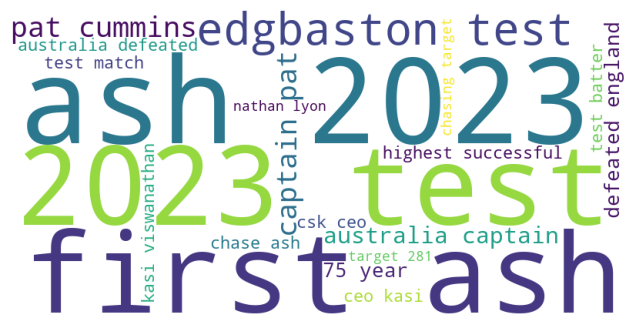

In [107]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_sports_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [108]:
top_20_tech_bigrams = (pd.Series(nltk.ngrams(tech_words, 2))
                      .value_counts()
                      .head(20))

top_20_tech_bigrams.head()

(narendra, modi)     8
(elon, musk)         8
(tesla, ceo)         5
(musk, said)         5
(prime, minister)    5
dtype: int64

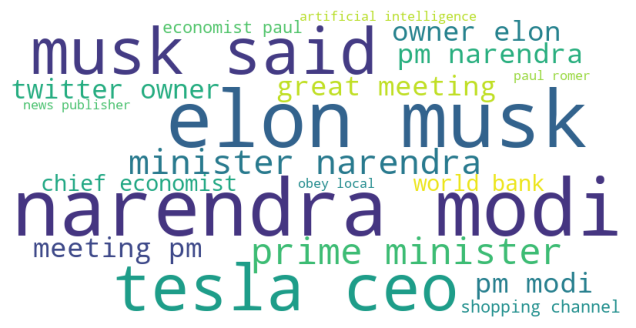

In [109]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [110]:
top_20_ent_bigrams = (pd.Series(nltk.ngrams(ent_words, 2))
                      .value_counts()
                      .head(20))

top_20_ent_bigrams.head()

(added, actress)    4
(teri, lanka)       4
(bigg, bos)         3
(pop, star)         2
(singh, said)       2
dtype: int64

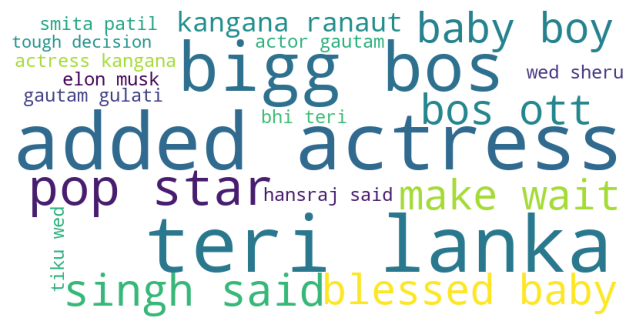

In [111]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ent_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()